**Disclaimer**

**I hereby declare that this mid-term project is my own original work and has not been submitted before
or copied from another source.**

# Business case

**Claim related fraud is a huge problem in the insurance industry. It is quite complex and difficult to identify those unwanted claims. With Machine Learning Algorithm, I am trying to troubleshoot and help the General Insurance industry with this problem.**

**The data that I have is from Automobile Insurance. I will be creating a predictive model that predicts if an insurance claim is fraudulent or not. The answere between YES/NO, is a Binary Classification task. **

**A comparison study has been performed to understand which ML algorithm suits best to the dataset.**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [19]:
df = pd.read_csv("ProcessedData.csv")

# Splitting the Data

In [63]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fraud_reported.values
y_val = df_val.fraud_reported.values
y_test = df_test.fraud_reported.values

del df_train['fraud_reported']
del df_val['fraud_reported']
del df_test['fraud_reported']

In [64]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [65]:
X_train.shape

(600, 158)

Feature column number changed from 33 to 158

In [66]:
from sklearn.metrics import confusion_matrix

def tpr_fpr_df(y_val, y_predict):
    
    score = []
    threshold = np.linspace(0, 1, 101)
    
    for t in threshold:
        fault_decision = (y_predict > t)
        cf = confusion_matrix(y_val, fault_decision)
        TN = cf[0, 0]
        TP = cf[1, 1]
        FP = cf[0, 1]
        FN = cf[1, 0]
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        score.append((t, TN, TP, FN, FP, TPR, FPR))
    
    columns = ['threshold', 'TN', 'TP', 'FN', 'FP', 'TPR', 'FPR']
    df = pd.DataFrame(score, columns = columns)
    return df

In [67]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fraud not reported', 'Fraud reported']); ax.yaxis.set_ticklabels(['Fraud not reported', 'Fraud reported'])

# Logistic Regression

In [317]:
from sklearn.linear_model import LogisticRegression

In [319]:
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lr.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.5979205827067668
Val auc: 0.5432692307692307


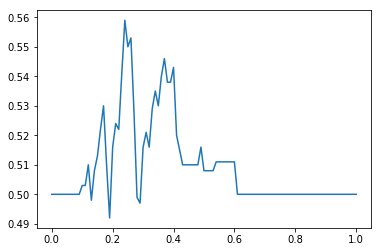

In [325]:
threshold = np.linspace(0, 1, 101)
score = []

for t in threshold:

    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')

    dv = DictVectorizer()
    dv.fit(train_dicts)
    
    X_train = dv.transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    y_predict = (y_pred >= t)

    auc = roc_auc_score(y_val, y_predict).round(3)
    
    score.append(auc)
    
plt.plot(threshold, score, label='auc')

In [326]:
def train(df, y_train, C):
    
    dicts = df.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    
    model.fit(X_train, y_train)
    
    return dv, model

In [327]:
def predict(df, dv, model):
    
    dicts = df.to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [334]:
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

n_splits = 5

C = [0.01, 0.1, 1, 10]
scores = []

for c in tqdm(C):
       
    lr = LogisticRegression(solver='liblinear', C=c, random_state=42)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)
        
scores

HBox(children=(FloatProgress(value=0.0, max=4.0), HTML(value='')))

[0.5498251748251748,
 0.5498251748251748,
 0.5432692307692307,
 0.5447261072261073]

Train auc: 0.5996387453007518
Val auc: 0.5498251748251748
accuracy score: 0.775


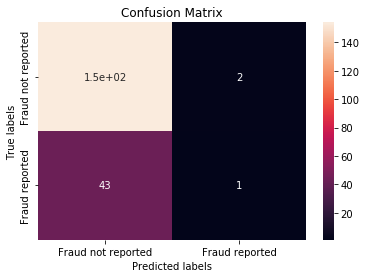

In [336]:
lr=LogisticRegression(solver='liblinear', C=0.01, max_iter=1000)

lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lr.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = lr.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

# Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [69]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 1.0
Val auc: 0.6762820512820512


above example shows Overfitting - fails to generalize the data

depth: 1, train_auc: 0.7828947368421053, val_auc: 0.7331002331002331
depth: 2, train_auc: 0.8521572485902256, val_auc: 0.824373543123543
depth: 3, train_auc: 0.8955371828007519, val_auc: 0.8458624708624709
depth: 4, train_auc: 0.9179907777255639, val_auc: 0.6918706293706294
depth: 5, train_auc: 0.9337406015037594, val_auc: 0.6783216783216784
depth: 6, train_auc: 0.9434181156015038, val_auc: 0.6216491841491842
depth: 7, train_auc: 0.9521337523496242, val_auc: 0.6099941724941725
depth: 8, train_auc: 0.9672961701127818, val_auc: 0.6727855477855479
depth: 9, train_auc: 0.9761660009398495, val_auc: 0.5868298368298368


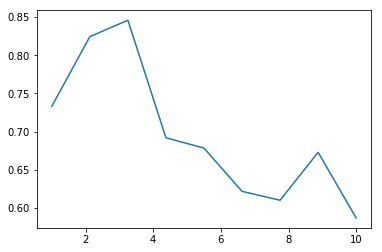

In [70]:
auc = []
x = np.linspace(1, 10, 9)

for i in range(1, 10):
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_pred)  
    
    print('depth: ' + str(i) + ', ' + 'train_auc: ' + str(train_auc) + ', val_auc: ' + str(val_auc))
    auc.append(val_auc)
    
plt.plot(x, auc)

In [71]:
scores = []

for depth in [2, 3, 4]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [72]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             2      3      4
min_samples_leaf                     
1                 0.824  0.846  0.737
5                 0.824  0.889  0.765
10                0.824  0.891  0.887
15                0.824  0.834  0.821
20                0.824  0.843  0.833
100               0.708  0.712  0.712
200               0.611  0.611  0.611
500               0.500  0.500  0.500

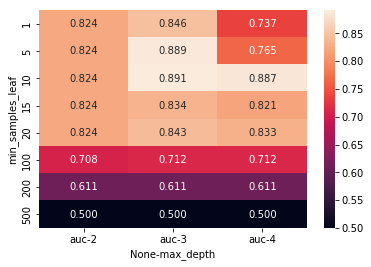

In [73]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

**best-depth: 3, best-min_saple_leaf: 10**

### Best Decision Tree model

In [315]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.8910214990601503
Val auc: 0.8913170163170163


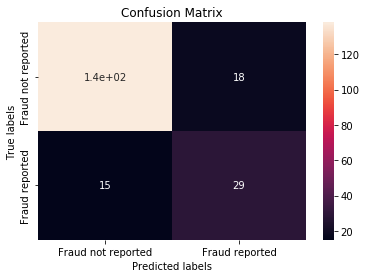

In [75]:
y_pred = dt.predict(X_val)
plot_confusion_matrix(y_val, y_pred)

Text(0, 0.5, 'TPR')

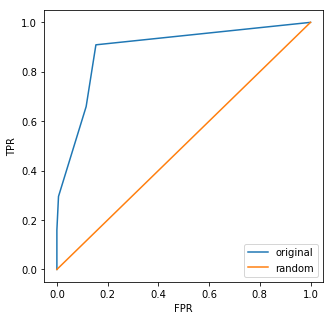

In [76]:
y_pred = dt.predict_proba(X_val)[:, 1]
df_ = tpr_fpr_df(y_val, y_pred)

plt.figure(figsize=(5, 5))

plt.plot(df_.FPR, df_.TPR, label='original')
plt.plot([0, 1], [0, 1], label='random')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

### Let's check with GridSearchCV to find the best parameters for Decision Tree

In [77]:
from sklearn.model_selection import GridSearchCV

parameters = {
     'max_depth': [2, 3, 4],
     'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200],
     }

treecv = DecisionTreeClassifier()

gscv = GridSearchCV(treecv, parameters, scoring='roc_auc', cv=10)
tree_cv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 3, 'min_samples_leaf': 10}


**As we can see GridSearchCV gives us the same results when compared to our manual tuning of hyper-parameter**

Let's use GridSearchCV to tune further parameters

In [78]:
parameters = {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': [3, 4, 5],
                'max_features': ['auto', 'sqrt', 'log2', None],
                'min_samples_leaf': [5, 10, 20],
                'min_samples_split': [2, 5, 10]
            }

treecv = DecisionTreeClassifier()

gscv = GridSearchCV(treecv, parameters, scoring='roc_auc', cv=5)
tree_cv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}


In [79]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=2, splitter='random')
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.8908746475563909
Val auc: 0.8913170163170163


In [80]:
from sklearn.metrics import classification_report

print('\n Classification Report:\n', classification_report(y_val, dt.predict(X_val)))


 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       156
           1       0.62      0.66      0.64        44

    accuracy                           0.83       200
   macro avg       0.76      0.77      0.77       200
weighted avg       0.84      0.83      0.84       200



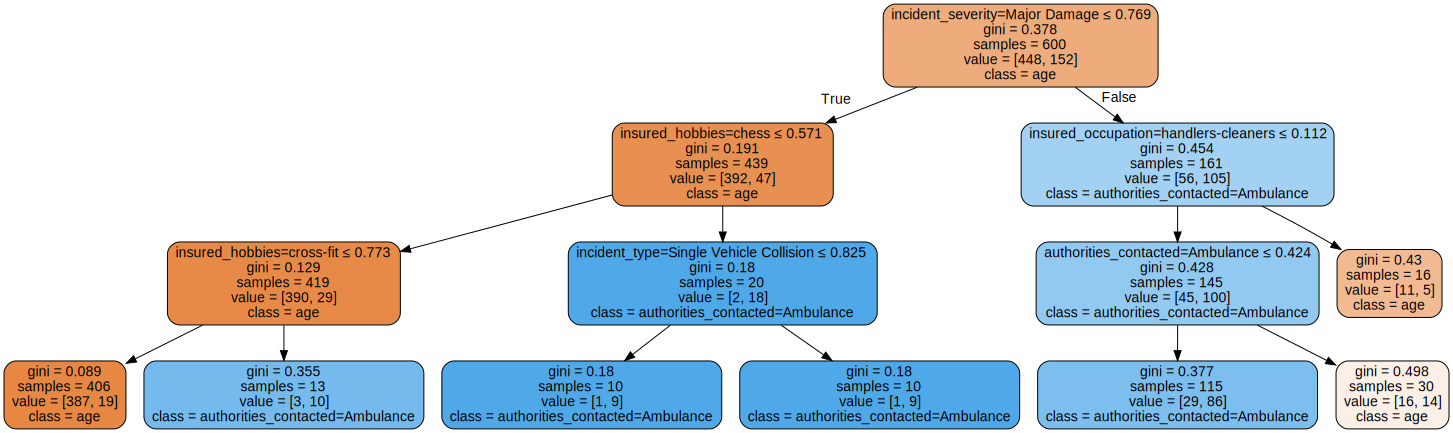

In [81]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("FraudDetection") 

dot_data = tree.export_graphviz(dt, out_file=None, 
                      feature_names=dv.get_feature_names(),  
                      class_names=dv.get_feature_names(),  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

**As we can see incident_severity=Major Damage is the main feature and we already figured it out during EDA**

**We saw that GridSearchCV gives the similar results, and is much easier to tune hyperparameter with GridSearchCV when compared to manual tuning**

**Hence, in this project GridSearchCV is used in further models to tune the hyperparameters**

### Best parameteres for Decision Tree

In [82]:
d = 3
l = 10
s = 2

dt = DecisionTreeClassifier(criterion='gini', 
                            max_depth=d, 
                            max_features=None, 
                            min_samples_leaf=l, 
                            min_samples_split=s, 
                            splitter='random')

dt

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, splitter='random')

# KNN

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNNscv = KNeighborsClassifier()

gscv = GridSearchCV(KNNscv, parameters, scoring='roc_auc', cv=10)
knn_cv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 2}


In [85]:
KNN = KNeighborsClassifier(algorithm='auto', 
                           n_neighbors= 6, 
                           p= 2)

KNN.fit(X_train, y_train)

y_pred = KNN.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = KNN.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.7944299224624061
Val auc: 0.5308857808857809


# Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
scores = []

for d in [2, 3, 4, 5, 6]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

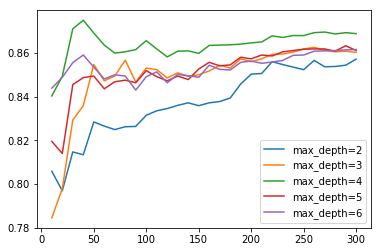

In [88]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [2, 3, 4, 5, 6]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [89]:
max_depth = 4
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 301, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

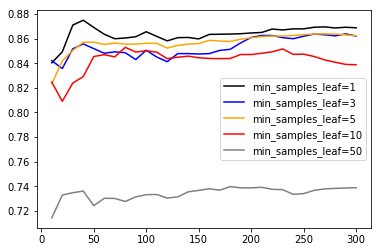

In [90]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [91]:
parameters = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 4, 5, 6],
        'min_samples_leaf': [1, 3, 5],
        'n_estimators': [100, 200, 300],
        'min_samples_split': [2, 5, 10]}

RF = RandomForestClassifier(random_state=1)

gscv = GridSearchCV(RF, parameters, scoring='roc_auc', cv=10, n_jobs=-1)
RFscv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", RFscv.best_params_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [92]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_depth=6,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = rf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.9833617246240601
Val auc: 0.8490675990675991


### Let's try with out manually tuned parameters

In [152]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_depth=4,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = rf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

Train auc: 0.9477502349624061
Val auc: 0.8655303030303031


In [153]:
print('\n Classification Report:\n', classification_report(y_val, rf.predict(X_val)))


 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       156
           1       0.75      0.07      0.12        44

    accuracy                           0.79       200
   macro avg       0.77      0.53      0.50       200
weighted avg       0.78      0.79      0.71       200



### As we can see we tend to get overfitting with GridSearchCV, this might be because of the small training dataset. Hence, we can not fully rely on GridSearchCV. It's a best practice to always see how it performs on Val Dataset

We will go the the manually tuned parameters

In [94]:
n = 100
d = 4
l = 1
s = 2

rf = RandomForestClassifier(criterion='entropy',
                            n_estimators = n,
                            max_depth = d,
                            min_samples_leaf = l,
                            min_samples_split = s,
                            random_state = 1)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, random_state=1)

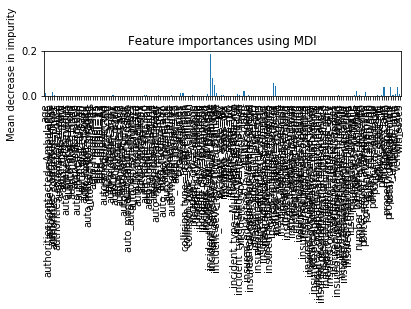

In [95]:
import time
import numpy as np

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=dv.get_feature_names())

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [96]:
importances.argmax(), dv.get_feature_names()[73]

(73, 'incident_severity=Major Damage')

**'incident_severity=Major Damage' is the main feature which affects the fraud reported claims the most**

### Best parameters for Random Forest

In [97]:
n = 100
d = 4
l = 1
s = 2

rf = RandomForestClassifier(criterion='entropy',
                            n_estimators = n,
                            max_depth = d,
                            min_samples_leaf = l,
                            min_samples_split = s,
                            random_state = 1)

rf

RandomForestClassifier(criterion='entropy', max_depth=4, random_state=1)

# Gradient boosting and XGBoost¶

In [98]:
import sys
!{sys.executable} -m pip install xgboost

import xgboost as xgb

You should consider upgrading via the 'C:\Users\Rajit_Sanghvi\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [217]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [100]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=40)

y_pred = model.predict(dtrain)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = model.predict(dval)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

[17:05:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 1.0
Val auc: 0.8623251748251748


In [101]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [102]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 4,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [103]:
s = output.stdout

In [104]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [105]:
df_score = parse_xgb_output(output)

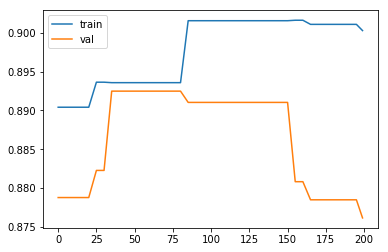

In [106]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [107]:
xgb_params = {
    'eta': [0.01, 0.05, 0.1, 0.3, 1.0], 
    'max_depth': [3, 6],
    'min_child_weight': [1, 10, 30],
    'gamma': [1, 3, 5],
    
    'objective': ['binary:logistic'],
    'nthread': [4],
    
    'seed': [1],
    'verbosity': [1],
}

xgb_model = xgb.XGBClassifier(random_state=1)

gscv = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc', cv=5, n_jobs=-1)
xgbscv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", xgbscv.best_params_)

C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
tuned hpyerparameters :(best parameters)  {'eta': 0.01, 'gamma': 5, 'max_depth': 6, 'min_child_weight': 1, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1, 'verbosity': 1}


### Best parameters for xgboost

In [108]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=75)

y_pred = model.predict(dtrain)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = model.predict(dval)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

[17:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.8935693726503758
Val auc: 0.8924825174825175


# OverSampling - SMOTE

One approach to addressing **imbalanced datasets** is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.

In [356]:
import sys
!{sys.executable} -m pip install imblearn

from imblearn.over_sampling import SMOTE

You should consider upgrading via the 'C:\Users\Rajit_Sanghvi\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [354]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 152 
Label 0, Before using SMOTE: 448 


In [355]:
OS = SMOTE(sampling_strategy=0.9, random_state=1)
X_train_OS, y_train_OS = OS.fit_resample(X_train, y_train)

dtrain_OS = xgb.DMatrix(X_train_OS, label=y_train_OS, feature_names=features)

In [353]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_OS==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_OS==0)))

Label 1, After using SMOTE: 403
Label 0, After using SMOTE: 448


In [313]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain_OS, num_boost_round=75)

y_pred = model.predict(dtrain_OS)
train_auc = roc_auc_score(y_train_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = model.predict(dval)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

[22:28:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.9653574751861043
Val auc: 0.8811917249417249


# LightGBM

In [117]:
import sys
!{sys.executable} -m pip install lightgbm

import lightgbm as lgb

You should consider upgrading via the 'C:\Users\Rajit_Sanghvi\Anaconda3\python.exe -m pip install --upgrade pip' command.
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.356599	valid_0's binary_logloss: 0.373635
[40]	training's binary_logloss: 0.328814	valid_0's binary_logloss: 0.375614
[60]	training's binary_logloss: 0.307254	valid_0's binary_logloss: 0.379614
[80]	training's binary_logloss: 0.291056	valid_0's binary_logloss: 0.387544
[100]	training's binary_logloss: 0.278128	valid_0's binary_logloss: 0.392378
Train auc: 0.8755874060150376
Val auc: 0.7572843822843822
accuracy score: 0.825


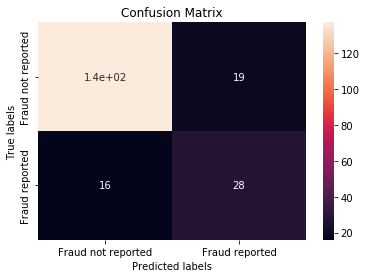

In [118]:
lgbmodel = lgb.LGBMClassifier(learning_rate=0.09, max_depth=2, random_state=11)

lgbmodel.fit(X_train, y_train,eval_set=[(X_val, y_val),(X_train, y_train)],
          verbose=20, eval_metric='logloss')

y_pred = lgbmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lgbmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

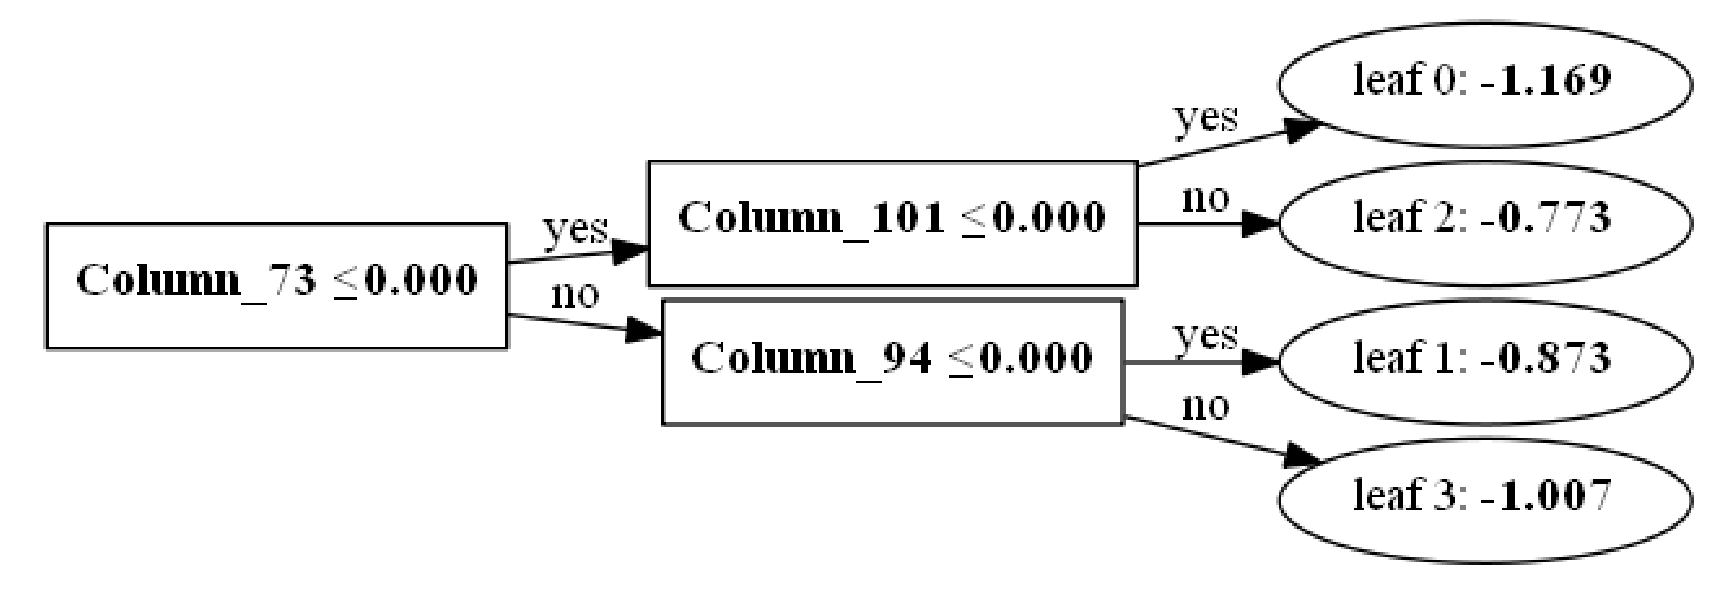

In [119]:
lgb.plot_tree(lgbmodel,figsize=(30,40))

In [120]:
dv.get_feature_names()[101], dv.get_feature_names()[94]

('insured_hobbies=chess', 'insured_education_level=Masters')

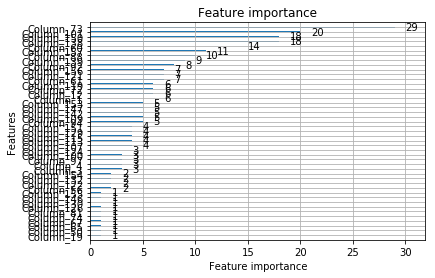

In [121]:
lgb.plot_importance(lgbmodel)

In [122]:
lgbmodel = lgb.LGBMClassifier()

grid_params = { 'boosting_type': ['gbdt'],
                'num_leaves': [3, 4, 6, 8, 12],
                'max_depth': [2, 3, 4, 6],
                'learning_rate': [0.01, 0.05, 0.1, 1, 5],
                'objective': ['binary', None], 
                'colsample_bytree': [0.65, 0.75, 0.8, 1], 
                'subsample': [0.7, 0.75], 
                'reg_alpha': [0, 1, 2, 6],
                'reg_lambda': [0, 1, 2, 6]}

gscv = GridSearchCV(lgbmodel, grid_params, scoring='roc_auc', cv=5, n_jobs=-1)
lgbscv = gscv.fit(X_train, y_train)


print("tuned hpyerparameters :(best parameters) ", lgbscv.best_params_)

tuned hpyerparameters :(best parameters)  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 1, 'max_depth': 2, 'num_leaves': 3, 'objective': 'binary', 'reg_alpha': 6, 'reg_lambda': 1, 'subsample': 0.7}


Train auc: 0.8510338345864662
Val auc: 0.8126456876456876
accuracy score: 0.835


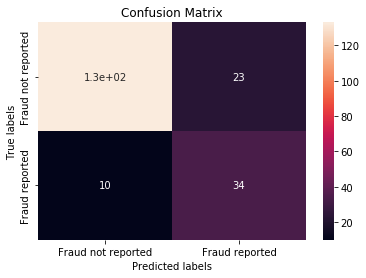

In [124]:
lgbmodel = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                              colsample_bytree = 1,
                              learning_rate = 1,
                              max_depth = 2,
                              num_leaves = 3,
                              objective = 'binary',
                              reg_alpha = 6,
                              reg_lambda = 1,
                              subsample = 0.7,
                              random_state=1)

lgbmodel.fit(X_train, y_train)

y_pred = lgbmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lgbmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

# OverSampling - SMOTE

In [128]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 152 
Label 0, Before using SMOTE: 448 


Text(0.5, 1.0, '% claims')

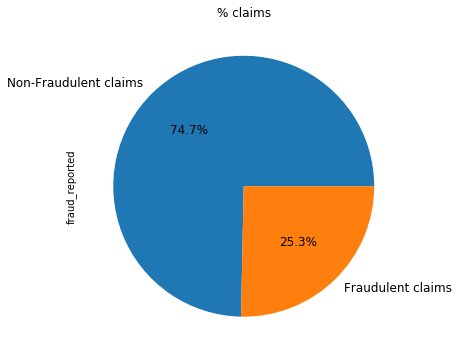

In [441]:
fig = plt.figure(figsize=(10,6))

y_train_df = pd.DataFrame(data=y_train, columns=["fraud_reported"])
             
data = y_train_df['fraud_reported'].value_counts()*100.0 /len(y_train_df)
ax = (data).plot.pie(autopct='%.1f%%', labels = ['Non-Fraudulent claims', 'Fraudulent claims'], fontsize=12)                                                                           
ax.set_title('% claims')

In [181]:
OS = SMOTE(sampling_strategy=0.8, random_state=1)
X_train_OS, y_train_OS = OS.fit_resample(X_train, y_train)

In [182]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_OS==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_OS==0)))

Label 1, After using SMOTE: 358
Label 0, After using SMOTE: 448


Text(0.5, 1.0, '% claims')

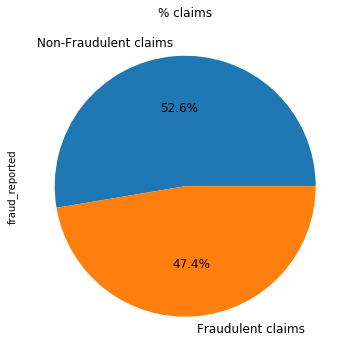

In [440]:
fig = plt.figure(figsize=(10,6))

y_train_OS_df = pd.DataFrame(data=y_train_OS, columns=["fraud_reported"])
             
data = y_train_OS_df['fraud_reported'].value_counts()*100.0 /len(y_train_OS_df)
ax = (data).plot.pie(autopct='%.1f%%', labels = ['Non-Fraudulent claims', 'Fraudulent claims'], fontsize=12)                                                                           
ax.set_title('% claims')

Train auc: 0.9123478651237031
Val auc: 0.8190559440559441
accuracy score: 0.845


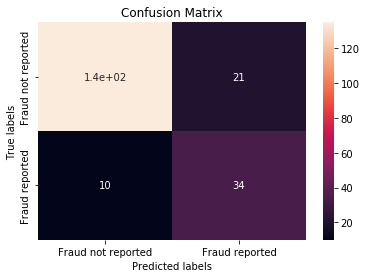

In [184]:
lgbmodel = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                              colsample_bytree = 1,
                              learning_rate = 1,
                              max_depth = 2,
                              num_leaves = 3,
                              objective = 'binary',
                              reg_alpha = 6,
                              reg_lambda = 1,
                              subsample = 0.7,
                              random_state=1)

lgbmodel.fit(X_train_OS, y_train_OS)

y_pred = lgbmodel.predict(X_train_OS)
train_auc = roc_auc_score(y_train_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lgbmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

**We can see that there's only very small improvement in performance with SMOTE method of about 0.8126 to about 0.8190**

### Under_Sampling - RandomUnderSampler

In [185]:
from imblearn.under_sampling import RandomUnderSampler

In [209]:
US = RandomUnderSampler(sampling_strategy=0.8, random_state=1)
X_train_US, y_train_US = US.fit_resample(X_train, y_train)

In [210]:
print("Label 1, Before using under_sampling: {} ".format(sum(y_train==1)))
print("Label 0, Before using under_sampling: {} ".format(sum(y_train==0)))

Label 1, Before using under_sampling: 152 
Label 0, Before using under_sampling: 448 


In [211]:
print("Label 1, After using under_sampling: {}".format(sum(y_train_US==1)))
print("Label 0, After using under_sampling: {}".format(sum(y_train_US==0)))

Label 1, After using under_sampling: 152
Label 0, After using under_sampling: 190


Train auc: 0.8335526315789473
Val auc: 0.8126456876456876
accuracy score: 0.835


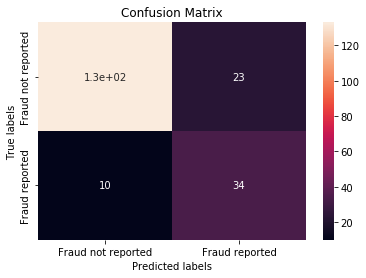

In [212]:
lgbmodel = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                              colsample_bytree = 1,
                              learning_rate = 1,
                              max_depth = 2,
                              num_leaves = 3,
                              objective = 'binary',
                              reg_alpha = 6,
                              reg_lambda = 1,
                              subsample = 0.7,
                              random_state=1)

lgbmodel.fit(X_train_US, y_train_US)

y_pred = lgbmodel.predict(X_train_US)
train_auc = roc_auc_score(y_train_US, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lgbmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

**val_auc didn't change after under_sampling**

# CatBoost

In [141]:
import sys
!{sys.executable} -m pip install catboost

from catboost import CatBoostClassifier

You should consider upgrading via the 'C:\Users\Rajit_Sanghvi\Anaconda3\python.exe -m pip install --upgrade pip' command.


Learning rate set to 0.008283
0:	learn: 0.6875426	total: 24.8ms	remaining: 24.8s
1:	learn: 0.6821660	total: 31.5ms	remaining: 15.7s
2:	learn: 0.6766091	total: 35.9ms	remaining: 11.9s
3:	learn: 0.6696075	total: 39.4ms	remaining: 9.81s
4:	learn: 0.6642194	total: 43.2ms	remaining: 8.59s
5:	learn: 0.6582390	total: 47.3ms	remaining: 7.83s
6:	learn: 0.6512223	total: 50.9ms	remaining: 7.22s
7:	learn: 0.6446676	total: 54.4ms	remaining: 6.75s
8:	learn: 0.6385827	total: 58.2ms	remaining: 6.41s
9:	learn: 0.6325313	total: 61.8ms	remaining: 6.12s
10:	learn: 0.6279685	total: 66.4ms	remaining: 5.97s
11:	learn: 0.6228312	total: 70.1ms	remaining: 5.77s
12:	learn: 0.6169317	total: 72.7ms	remaining: 5.52s
13:	learn: 0.6113642	total: 76.5ms	remaining: 5.39s
14:	learn: 0.6065488	total: 80.1ms	remaining: 5.26s
15:	learn: 0.6015903	total: 84.3ms	remaining: 5.18s
16:	learn: 0.5974461	total: 88.8ms	remaining: 5.13s
17:	learn: 0.5937295	total: 90.9ms	remaining: 4.96s
18:	learn: 0.5891528	total: 94.7ms	remaining

215:	learn: 0.2850869	total: 777ms	remaining: 2.82s
216:	learn: 0.2846277	total: 781ms	remaining: 2.82s
217:	learn: 0.2842944	total: 784ms	remaining: 2.81s
218:	learn: 0.2838229	total: 788ms	remaining: 2.81s
219:	learn: 0.2835635	total: 792ms	remaining: 2.81s
220:	learn: 0.2832298	total: 796ms	remaining: 2.81s
221:	learn: 0.2829469	total: 800ms	remaining: 2.8s
222:	learn: 0.2823936	total: 804ms	remaining: 2.8s
223:	learn: 0.2819781	total: 807ms	remaining: 2.79s
224:	learn: 0.2815444	total: 810ms	remaining: 2.79s
225:	learn: 0.2812925	total: 813ms	remaining: 2.78s
226:	learn: 0.2810067	total: 816ms	remaining: 2.78s
227:	learn: 0.2803387	total: 820ms	remaining: 2.77s
228:	learn: 0.2798346	total: 823ms	remaining: 2.77s
229:	learn: 0.2794231	total: 826ms	remaining: 2.76s
230:	learn: 0.2790750	total: 829ms	remaining: 2.76s
231:	learn: 0.2786517	total: 832ms	remaining: 2.75s
232:	learn: 0.2784422	total: 835ms	remaining: 2.75s
233:	learn: 0.2780668	total: 838ms	remaining: 2.74s
234:	learn: 0.

389:	learn: 0.2314037	total: 1.36s	remaining: 2.13s
390:	learn: 0.2312726	total: 1.36s	remaining: 2.13s
391:	learn: 0.2310651	total: 1.37s	remaining: 2.12s
392:	learn: 0.2305845	total: 1.37s	remaining: 2.12s
393:	learn: 0.2302509	total: 1.38s	remaining: 2.12s
394:	learn: 0.2299203	total: 1.38s	remaining: 2.12s
395:	learn: 0.2294112	total: 1.38s	remaining: 2.11s
396:	learn: 0.2290425	total: 1.39s	remaining: 2.11s
397:	learn: 0.2288686	total: 1.39s	remaining: 2.1s
398:	learn: 0.2286422	total: 1.39s	remaining: 2.1s
399:	learn: 0.2282890	total: 1.4s	remaining: 2.1s
400:	learn: 0.2280762	total: 1.4s	remaining: 2.09s
401:	learn: 0.2277373	total: 1.4s	remaining: 2.09s
402:	learn: 0.2275674	total: 1.41s	remaining: 2.08s
403:	learn: 0.2272770	total: 1.41s	remaining: 2.08s
404:	learn: 0.2270517	total: 1.42s	remaining: 2.08s
405:	learn: 0.2267543	total: 1.42s	remaining: 2.08s
406:	learn: 0.2264381	total: 1.42s	remaining: 2.07s
407:	learn: 0.2262997	total: 1.43s	remaining: 2.07s
408:	learn: 0.2261

603:	learn: 0.1837084	total: 2.14s	remaining: 1.4s
604:	learn: 0.1834412	total: 2.15s	remaining: 1.4s
605:	learn: 0.1831488	total: 2.15s	remaining: 1.4s
606:	learn: 0.1829410	total: 2.15s	remaining: 1.39s
607:	learn: 0.1827274	total: 2.16s	remaining: 1.39s
608:	learn: 0.1825592	total: 2.16s	remaining: 1.39s
609:	learn: 0.1823212	total: 2.17s	remaining: 1.39s
610:	learn: 0.1821002	total: 2.17s	remaining: 1.38s
611:	learn: 0.1819455	total: 2.17s	remaining: 1.38s
612:	learn: 0.1817698	total: 2.18s	remaining: 1.37s
613:	learn: 0.1816360	total: 2.18s	remaining: 1.37s
614:	learn: 0.1814508	total: 2.18s	remaining: 1.37s
615:	learn: 0.1813558	total: 2.19s	remaining: 1.36s
616:	learn: 0.1812044	total: 2.19s	remaining: 1.36s
617:	learn: 0.1810520	total: 2.19s	remaining: 1.35s
618:	learn: 0.1808649	total: 2.2s	remaining: 1.35s
619:	learn: 0.1807333	total: 2.2s	remaining: 1.35s
620:	learn: 0.1805849	total: 2.2s	remaining: 1.34s
621:	learn: 0.1803213	total: 2.21s	remaining: 1.34s
622:	learn: 0.1800

767:	learn: 0.1560553	total: 2.72s	remaining: 822ms
768:	learn: 0.1557931	total: 2.72s	remaining: 819ms
769:	learn: 0.1556105	total: 2.73s	remaining: 815ms
770:	learn: 0.1554658	total: 2.73s	remaining: 812ms
771:	learn: 0.1552793	total: 2.74s	remaining: 808ms
772:	learn: 0.1551120	total: 2.74s	remaining: 805ms
773:	learn: 0.1549902	total: 2.75s	remaining: 802ms
774:	learn: 0.1547973	total: 2.75s	remaining: 799ms
775:	learn: 0.1547675	total: 2.75s	remaining: 795ms
776:	learn: 0.1546314	total: 2.76s	remaining: 791ms
777:	learn: 0.1545731	total: 2.76s	remaining: 788ms
778:	learn: 0.1544832	total: 2.76s	remaining: 784ms
779:	learn: 0.1543481	total: 2.77s	remaining: 781ms
780:	learn: 0.1542157	total: 2.77s	remaining: 777ms
781:	learn: 0.1541922	total: 2.77s	remaining: 773ms
782:	learn: 0.1540315	total: 2.78s	remaining: 770ms
783:	learn: 0.1538484	total: 2.78s	remaining: 766ms
784:	learn: 0.1535583	total: 2.78s	remaining: 763ms
785:	learn: 0.1533315	total: 2.79s	remaining: 759ms
786:	learn: 

930:	learn: 0.1337496	total: 3.3s	remaining: 245ms
931:	learn: 0.1336632	total: 3.31s	remaining: 241ms
932:	learn: 0.1335051	total: 3.31s	remaining: 238ms
933:	learn: 0.1333699	total: 3.31s	remaining: 234ms
934:	learn: 0.1331567	total: 3.32s	remaining: 231ms
935:	learn: 0.1330372	total: 3.32s	remaining: 227ms
936:	learn: 0.1328869	total: 3.33s	remaining: 224ms
937:	learn: 0.1327536	total: 3.33s	remaining: 220ms
938:	learn: 0.1326003	total: 3.33s	remaining: 217ms
939:	learn: 0.1324383	total: 3.34s	remaining: 213ms
940:	learn: 0.1322160	total: 3.34s	remaining: 210ms
941:	learn: 0.1321951	total: 3.35s	remaining: 206ms
942:	learn: 0.1320486	total: 3.35s	remaining: 202ms
943:	learn: 0.1320206	total: 3.35s	remaining: 199ms
944:	learn: 0.1318587	total: 3.36s	remaining: 195ms
945:	learn: 0.1316606	total: 3.36s	remaining: 192ms
946:	learn: 0.1314643	total: 3.36s	remaining: 188ms
947:	learn: 0.1313643	total: 3.37s	remaining: 185ms
948:	learn: 0.1311606	total: 3.37s	remaining: 181ms
949:	learn: 0

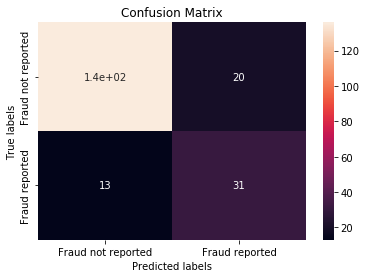

In [250]:
catmodel = CatBoostClassifier()

catmodel.fit(X_train, y_train)

y_pred = catmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

In [253]:
catmodel = CatBoostClassifier()

cat_params = {'depth':[2, 3, 4, 5, 6],
              'iterations':[250, 100, 500, 1000],
              'learning_rate':[0.03, 0.001, 0.01, 0.1, 0.3], 
              'l2_leaf_reg':[3, 1, 5, 10, 100],
            }

gscv = GridSearchCV(catmodel, cat_params, scoring='roc_auc', cv=5, n_jobs=-1)
catscv = gscv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ", catscv.best_params_)

0:	learn: 0.6868442	total: 2.44ms	remaining: 1.22s
1:	learn: 0.6798156	total: 3.94ms	remaining: 981ms
2:	learn: 0.6718506	total: 4.92ms	remaining: 816ms
3:	learn: 0.6658994	total: 5.87ms	remaining: 728ms
4:	learn: 0.6601724	total: 6.86ms	remaining: 680ms
5:	learn: 0.6544796	total: 7.89ms	remaining: 649ms
6:	learn: 0.6489683	total: 8.94ms	remaining: 630ms
7:	learn: 0.6435512	total: 10ms	remaining: 616ms
8:	learn: 0.6383340	total: 11ms	remaining: 601ms
9:	learn: 0.6314150	total: 12ms	remaining: 586ms
10:	learn: 0.6264768	total: 13.1ms	remaining: 581ms
11:	learn: 0.6217087	total: 14ms	remaining: 569ms
12:	learn: 0.6152132	total: 15ms	remaining: 564ms
13:	learn: 0.6106135	total: 16.1ms	remaining: 559ms
14:	learn: 0.6060771	total: 17ms	remaining: 551ms
15:	learn: 0.6016271	total: 18.4ms	remaining: 555ms
16:	learn: 0.5973280	total: 19.5ms	remaining: 553ms
17:	learn: 0.5914537	total: 20.5ms	remaining: 549ms
18:	learn: 0.5857286	total: 21.6ms	remaining: 547ms
19:	learn: 0.5817353	total: 22.6ms

312:	learn: 0.3388072	total: 348ms	remaining: 208ms
313:	learn: 0.3386270	total: 349ms	remaining: 207ms
314:	learn: 0.3385140	total: 350ms	remaining: 205ms
315:	learn: 0.3384583	total: 351ms	remaining: 204ms
316:	learn: 0.3383730	total: 352ms	remaining: 203ms
317:	learn: 0.3381734	total: 353ms	remaining: 202ms
318:	learn: 0.3380754	total: 354ms	remaining: 201ms
319:	learn: 0.3379930	total: 355ms	remaining: 200ms
320:	learn: 0.3376825	total: 356ms	remaining: 198ms
321:	learn: 0.3375666	total: 357ms	remaining: 197ms
322:	learn: 0.3373427	total: 359ms	remaining: 196ms
323:	learn: 0.3370400	total: 360ms	remaining: 196ms
324:	learn: 0.3370261	total: 361ms	remaining: 194ms
325:	learn: 0.3369052	total: 362ms	remaining: 193ms
326:	learn: 0.3367794	total: 363ms	remaining: 192ms
327:	learn: 0.3366426	total: 365ms	remaining: 192ms
328:	learn: 0.3365063	total: 367ms	remaining: 191ms
329:	learn: 0.3362138	total: 368ms	remaining: 190ms
330:	learn: 0.3359756	total: 369ms	remaining: 188ms
331:	learn: 

tuned hpyerparameters :(best parameters)  {'depth': 2, 'iterations': 500, 'l2_leaf_reg': 10, 'learning_rate': 0.01}


0:	learn: 0.6868442	total: 1.64ms	remaining: 820ms
1:	learn: 0.6798156	total: 3.5ms	remaining: 873ms
2:	learn: 0.6718506	total: 4.96ms	remaining: 822ms
3:	learn: 0.6658994	total: 6.47ms	remaining: 802ms
4:	learn: 0.6601724	total: 7.79ms	remaining: 771ms
5:	learn: 0.6544796	total: 9.33ms	remaining: 768ms
6:	learn: 0.6489683	total: 10.4ms	remaining: 734ms
7:	learn: 0.6435512	total: 11.4ms	remaining: 704ms
8:	learn: 0.6383340	total: 12.6ms	remaining: 686ms
9:	learn: 0.6314150	total: 13.5ms	remaining: 661ms
10:	learn: 0.6264768	total: 14.3ms	remaining: 637ms
11:	learn: 0.6217087	total: 15.1ms	remaining: 616ms
12:	learn: 0.6152132	total: 16ms	remaining: 598ms
13:	learn: 0.6106135	total: 17ms	remaining: 590ms
14:	learn: 0.6060771	total: 18ms	remaining: 580ms
15:	learn: 0.6016271	total: 18.9ms	remaining: 571ms
16:	learn: 0.5973280	total: 19.8ms	remaining: 562ms
17:	learn: 0.5914537	total: 20.8ms	remaining: 556ms
18:	learn: 0.5857286	total: 21.7ms	remaining: 549ms
19:	learn: 0.5817353	total: 2

187:	learn: 0.3643528	total: 178ms	remaining: 296ms
188:	learn: 0.3640727	total: 180ms	remaining: 296ms
189:	learn: 0.3637329	total: 181ms	remaining: 295ms
190:	learn: 0.3634841	total: 182ms	remaining: 294ms
191:	learn: 0.3633910	total: 183ms	remaining: 294ms
192:	learn: 0.3631957	total: 184ms	remaining: 292ms
193:	learn: 0.3626404	total: 185ms	remaining: 291ms
194:	learn: 0.3623218	total: 186ms	remaining: 290ms
195:	learn: 0.3620218	total: 187ms	remaining: 289ms
196:	learn: 0.3617703	total: 188ms	remaining: 290ms
197:	learn: 0.3612361	total: 190ms	remaining: 289ms
198:	learn: 0.3607782	total: 191ms	remaining: 289ms
199:	learn: 0.3605551	total: 192ms	remaining: 288ms
200:	learn: 0.3602484	total: 193ms	remaining: 287ms
201:	learn: 0.3600231	total: 194ms	remaining: 286ms
202:	learn: 0.3598247	total: 195ms	remaining: 285ms
203:	learn: 0.3594880	total: 195ms	remaining: 284ms
204:	learn: 0.3589812	total: 196ms	remaining: 282ms
205:	learn: 0.3588239	total: 197ms	remaining: 281ms
206:	learn: 

365:	learn: 0.3319141	total: 351ms	remaining: 128ms
366:	learn: 0.3317074	total: 352ms	remaining: 128ms
367:	learn: 0.3315873	total: 353ms	remaining: 127ms
368:	learn: 0.3313800	total: 354ms	remaining: 126ms
369:	learn: 0.3312858	total: 355ms	remaining: 125ms
370:	learn: 0.3311613	total: 356ms	remaining: 124ms
371:	learn: 0.3311253	total: 357ms	remaining: 123ms
372:	learn: 0.3310215	total: 358ms	remaining: 122ms
373:	learn: 0.3309040	total: 359ms	remaining: 121ms
374:	learn: 0.3308235	total: 360ms	remaining: 120ms
375:	learn: 0.3307917	total: 361ms	remaining: 119ms
376:	learn: 0.3307222	total: 362ms	remaining: 118ms
377:	learn: 0.3306552	total: 363ms	remaining: 117ms
378:	learn: 0.3305724	total: 364ms	remaining: 116ms
379:	learn: 0.3305028	total: 365ms	remaining: 115ms
380:	learn: 0.3303553	total: 366ms	remaining: 114ms
381:	learn: 0.3302301	total: 367ms	remaining: 113ms
382:	learn: 0.3301427	total: 368ms	remaining: 112ms
383:	learn: 0.3300917	total: 369ms	remaining: 112ms
384:	learn: 

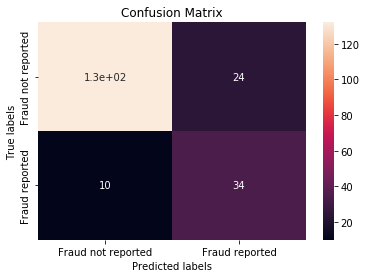

In [254]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10)

catmodel.fit(X_train, y_train)

y_pred = catmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

0:	learn: 0.6866823	total: 2.55ms	remaining: 1.27s
1:	learn: 0.6804464	total: 5.1ms	remaining: 1.27s
2:	learn: 0.6743515	total: 7.57ms	remaining: 1.25s
3:	learn: 0.6684240	total: 10ms	remaining: 1.24s
4:	learn: 0.6607553	total: 12.5ms	remaining: 1.24s
5:	learn: 0.6551955	total: 14ms	remaining: 1.16s
6:	learn: 0.6495985	total: 15.7ms	remaining: 1.11s
7:	learn: 0.6441802	total: 17.3ms	remaining: 1.06s
8:	learn: 0.6371251	total: 18.5ms	remaining: 1.01s
9:	learn: 0.6320033	total: 19.8ms	remaining: 972ms
10:	learn: 0.6270413	total: 21.2ms	remaining: 940ms
11:	learn: 0.6222269	total: 22.1ms	remaining: 900ms
12:	learn: 0.6174896	total: 23.2ms	remaining: 868ms
13:	learn: 0.6128491	total: 24.2ms	remaining: 841ms
14:	learn: 0.6083270	total: 25.5ms	remaining: 825ms
15:	learn: 0.6038866	total: 26.4ms	remaining: 799ms
16:	learn: 0.5978607	total: 27.3ms	remaining: 776ms
17:	learn: 0.5936232	total: 28.1ms	remaining: 753ms
18:	learn: 0.5878578	total: 29.1ms	remaining: 736ms
19:	learn: 0.5838914	total:

186:	learn: 0.3649411	total: 173ms	remaining: 289ms
187:	learn: 0.3646349	total: 174ms	remaining: 288ms
188:	learn: 0.3643765	total: 175ms	remaining: 288ms
189:	learn: 0.3637786	total: 176ms	remaining: 287ms
190:	learn: 0.3633862	total: 177ms	remaining: 286ms
191:	learn: 0.3630019	total: 178ms	remaining: 285ms
192:	learn: 0.3627678	total: 179ms	remaining: 284ms
193:	learn: 0.3625564	total: 179ms	remaining: 283ms
194:	learn: 0.3622866	total: 180ms	remaining: 282ms
195:	learn: 0.3620399	total: 181ms	remaining: 281ms
196:	learn: 0.3617911	total: 182ms	remaining: 280ms
197:	learn: 0.3615319	total: 183ms	remaining: 279ms
198:	learn: 0.3613104	total: 184ms	remaining: 278ms
199:	learn: 0.3609431	total: 185ms	remaining: 277ms
200:	learn: 0.3604863	total: 186ms	remaining: 276ms
201:	learn: 0.3602444	total: 187ms	remaining: 275ms
202:	learn: 0.3600468	total: 187ms	remaining: 274ms
203:	learn: 0.3597437	total: 188ms	remaining: 273ms
204:	learn: 0.3595783	total: 189ms	remaining: 272ms
205:	learn: 

388:	learn: 0.3302309	total: 348ms	remaining: 99.3ms
389:	learn: 0.3301439	total: 349ms	remaining: 98.5ms
390:	learn: 0.3300269	total: 350ms	remaining: 97.5ms
391:	learn: 0.3299740	total: 351ms	remaining: 96.7ms
392:	learn: 0.3298765	total: 352ms	remaining: 95.8ms
393:	learn: 0.3298500	total: 353ms	remaining: 94.9ms
394:	learn: 0.3297740	total: 354ms	remaining: 94ms
395:	learn: 0.3297605	total: 355ms	remaining: 93.1ms
396:	learn: 0.3295957	total: 355ms	remaining: 92.2ms
397:	learn: 0.3293935	total: 356ms	remaining: 91.3ms
398:	learn: 0.3293796	total: 357ms	remaining: 90.4ms
399:	learn: 0.3293252	total: 358ms	remaining: 89.5ms
400:	learn: 0.3292081	total: 359ms	remaining: 88.6ms
401:	learn: 0.3289489	total: 360ms	remaining: 87.7ms
402:	learn: 0.3287812	total: 361ms	remaining: 86.8ms
403:	learn: 0.3287320	total: 362ms	remaining: 86ms
404:	learn: 0.3284804	total: 363ms	remaining: 85.1ms
405:	learn: 0.3284037	total: 364ms	remaining: 84.2ms
406:	learn: 0.3282392	total: 365ms	remaining: 83.3

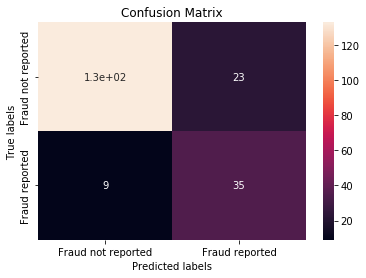

In [265]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10,
                              border_count = 100
                            )

catmodel.fit(X_train, y_train)

y_pred = catmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

### CatBoost with SMOTE

In [292]:
US = RandomUnderSampler(sampling_strategy=0.8, random_state=1)
X_train_US, y_train_US = US.fit_resample(X_train, y_train)

0:	learn: 0.6851784	total: 4.73ms	remaining: 2.36s
1:	learn: 0.6782167	total: 9.05ms	remaining: 2.25s
2:	learn: 0.6727235	total: 13.3ms	remaining: 2.2s
3:	learn: 0.6671742	total: 17.4ms	remaining: 2.16s
4:	learn: 0.6617134	total: 20.1ms	remaining: 1.99s
5:	learn: 0.6552865	total: 23ms	remaining: 1.89s
6:	learn: 0.6479308	total: 25.3ms	remaining: 1.78s
7:	learn: 0.6412862	total: 27.2ms	remaining: 1.67s
8:	learn: 0.6348146	total: 29ms	remaining: 1.58s
9:	learn: 0.6288034	total: 30.7ms	remaining: 1.5s
10:	learn: 0.6241586	total: 32.3ms	remaining: 1.43s
11:	learn: 0.6188647	total: 33.7ms	remaining: 1.37s
12:	learn: 0.6124005	total: 35.1ms	remaining: 1.31s
13:	learn: 0.6068739	total: 36.6ms	remaining: 1.27s
14:	learn: 0.6027075	total: 38ms	remaining: 1.23s
15:	learn: 0.5987506	total: 39.5ms	remaining: 1.2s
16:	learn: 0.5936862	total: 41.1ms	remaining: 1.17s
17:	learn: 0.5890747	total: 42.6ms	remaining: 1.14s
18:	learn: 0.5854410	total: 44ms	remaining: 1.11s
19:	learn: 0.5816975	total: 45.3m

237:	learn: 0.3175940	total: 372ms	remaining: 410ms
238:	learn: 0.3171890	total: 374ms	remaining: 409ms
239:	learn: 0.3167941	total: 376ms	remaining: 407ms
240:	learn: 0.3164870	total: 377ms	remaining: 406ms
241:	learn: 0.3160661	total: 379ms	remaining: 404ms
242:	learn: 0.3158980	total: 381ms	remaining: 403ms
243:	learn: 0.3156672	total: 382ms	remaining: 401ms
244:	learn: 0.3153624	total: 384ms	remaining: 400ms
245:	learn: 0.3151718	total: 386ms	remaining: 398ms
246:	learn: 0.3147329	total: 387ms	remaining: 397ms
247:	learn: 0.3145648	total: 389ms	remaining: 395ms
248:	learn: 0.3142938	total: 391ms	remaining: 394ms
249:	learn: 0.3141228	total: 393ms	remaining: 393ms
250:	learn: 0.3137426	total: 395ms	remaining: 392ms
251:	learn: 0.3135491	total: 397ms	remaining: 391ms
252:	learn: 0.3133779	total: 399ms	remaining: 389ms
253:	learn: 0.3126834	total: 400ms	remaining: 388ms
254:	learn: 0.3123586	total: 402ms	remaining: 386ms
255:	learn: 0.3120736	total: 403ms	remaining: 384ms
256:	learn: 

484:	learn: 0.2703983	total: 738ms	remaining: 22.8ms
485:	learn: 0.2700564	total: 740ms	remaining: 21.3ms
486:	learn: 0.2699258	total: 742ms	remaining: 19.8ms
487:	learn: 0.2698329	total: 743ms	remaining: 18.3ms
488:	learn: 0.2696927	total: 746ms	remaining: 16.8ms
489:	learn: 0.2696257	total: 748ms	remaining: 15.3ms
490:	learn: 0.2695368	total: 750ms	remaining: 13.7ms
491:	learn: 0.2693764	total: 752ms	remaining: 12.2ms
492:	learn: 0.2693373	total: 754ms	remaining: 10.7ms
493:	learn: 0.2692393	total: 756ms	remaining: 9.18ms
494:	learn: 0.2691421	total: 758ms	remaining: 7.65ms
495:	learn: 0.2691049	total: 759ms	remaining: 6.12ms
496:	learn: 0.2690257	total: 761ms	remaining: 4.59ms
497:	learn: 0.2688922	total: 763ms	remaining: 3.06ms
498:	learn: 0.2687975	total: 766ms	remaining: 1.53ms
499:	learn: 0.2687193	total: 767ms	remaining: 0us
Train auc: 0.9067318769939738
Val auc: 0.8776223776223776
accuracy score: 0.86


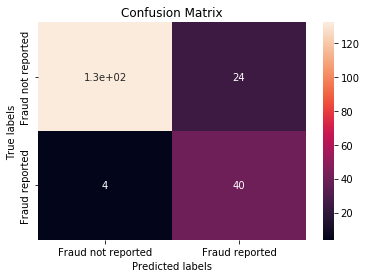

In [297]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10,
                              border_count = 100
                            )

catmodel.fit(X_train_OS, y_train_OS)

y_pred = catmodel.predict(X_train_OS)
train_auc = roc_auc_score(y_train_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

# Model summary

Train auc: 0.8908746475563909
Val auc: 0.8913170163170163
accuracy score: 0.835


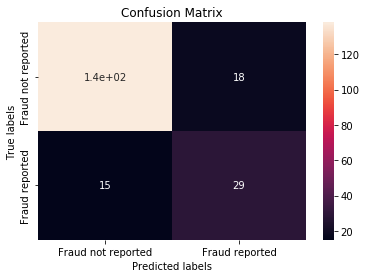

In [267]:
dt = DecisionTreeClassifier(criterion='gini', 
                            max_depth=3, 
                            max_features=None, 
                            min_samples_leaf=10, 
                            min_samples_split=2, 
                            splitter='random')
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = dt.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

In [268]:
print('\n Classification Report:\n', classification_report(y_val, dt.predict(X_val)))


 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       156
           1       0.62      0.66      0.64        44

    accuracy                           0.83       200
   macro avg       0.76      0.77      0.77       200
weighted avg       0.84      0.83      0.84       200



In [269]:
KNN = KNeighborsClassifier(algorithm='auto', n_neighbors= 6, p= 2)

KNN.fit(X_train, y_train)

y_pred = KNN.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = KNN.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = KNN.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

Train auc: 0.7944299224624061
Val auc: 0.5308857808857809
accuracy score: 0.75


In [270]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_depth=4,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            random_state=1)

rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = rf.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = rf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

Train auc: 0.9477502349624061
Val auc: 0.8655303030303031
accuracy score: 0.79


In [271]:
print('\n Classification Report:\n', classification_report(y_val, rf.predict(X_val)))


 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       156
           1       0.75      0.07      0.12        44

    accuracy                           0.79       200
   macro avg       0.77      0.53      0.50       200
weighted avg       0.78      0.79      0.71       200



[09:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.8935693726503758
Val auc: 0.8924825174825175
accuracy score: 0.86


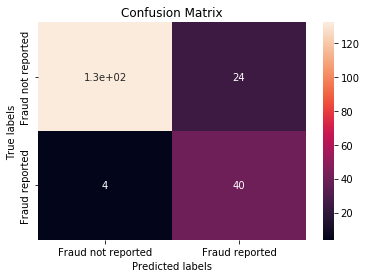

In [343]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

xgbmodel = xgb.train(xgb_params, dtrain, num_boost_round=75)

y_pred = xgbmodel.predict(dtrain)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = xgbmodel.predict(dval)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = xgbmodel.predict(dval)
y_pred = (y_pred > 0.5)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

[22:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.9653574751861043
Val auc: 0.8811917249417249
accuracy score: 0.85


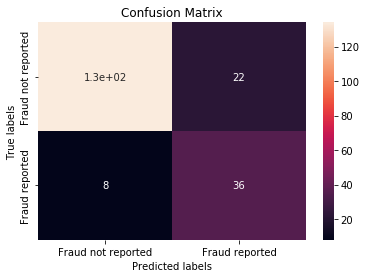

In [314]:
OS = SMOTE(sampling_strategy=0.9, random_state=1)
X_train_OS, y_train_OS = OS.fit_resample(X_train, y_train)
dtrain_OS = xgb.DMatrix(X_train_OS, label=y_train_OS, feature_names=features)

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

xgbmodel = xgb.train(xgb_params, dtrain_OS, num_boost_round=75)

y_pred = xgbmodel.predict(dtrain_OS)
train_auc = roc_auc_score(y_train_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = xgbmodel.predict(dval)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

y_pred = xgbmodel.predict(dval)
y_pred = (y_pred > 0.5)
acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

Train auc: 0.8510338345864662
Val auc: 0.8126456876456876
accuracy score: 0.835


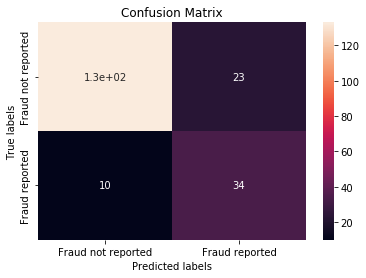

In [273]:
lgbmodel = lgb.LGBMClassifier(boosting_type= 'gbdt', 
                              colsample_bytree = 1,
                              learning_rate = 1,
                              max_depth = 2,
                              num_leaves = 3,
                              objective = 'binary',
                              reg_alpha = 6,
                              reg_lambda = 1,
                              subsample = 0.7,
                              random_state=1)

lgbmodel.fit(X_train, y_train)

y_pred = lgbmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = lgbmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

0:	learn: 0.6866823	total: 2.29ms	remaining: 1.14s
1:	learn: 0.6804464	total: 4.83ms	remaining: 1.2s
2:	learn: 0.6743515	total: 6.95ms	remaining: 1.15s
3:	learn: 0.6684240	total: 8.8ms	remaining: 1.09s
4:	learn: 0.6607553	total: 10.6ms	remaining: 1.05s
5:	learn: 0.6551955	total: 12.1ms	remaining: 995ms
6:	learn: 0.6495985	total: 13.4ms	remaining: 947ms
7:	learn: 0.6441802	total: 14.6ms	remaining: 901ms
8:	learn: 0.6371251	total: 16ms	remaining: 871ms
9:	learn: 0.6320033	total: 17ms	remaining: 833ms
10:	learn: 0.6270413	total: 17.9ms	remaining: 796ms
11:	learn: 0.6222269	total: 19ms	remaining: 772ms
12:	learn: 0.6174896	total: 20.1ms	remaining: 751ms
13:	learn: 0.6128491	total: 21ms	remaining: 729ms
14:	learn: 0.6083270	total: 21.9ms	remaining: 709ms
15:	learn: 0.6038866	total: 22.8ms	remaining: 689ms
16:	learn: 0.5978607	total: 23.6ms	remaining: 670ms
17:	learn: 0.5936232	total: 24.4ms	remaining: 653ms
18:	learn: 0.5878578	total: 25.3ms	remaining: 640ms
19:	learn: 0.5838914	total: 26.1

197:	learn: 0.3615319	total: 177ms	remaining: 270ms
198:	learn: 0.3613104	total: 178ms	remaining: 269ms
199:	learn: 0.3609431	total: 179ms	remaining: 268ms
200:	learn: 0.3604863	total: 180ms	remaining: 268ms
201:	learn: 0.3602444	total: 181ms	remaining: 267ms
202:	learn: 0.3600468	total: 182ms	remaining: 266ms
203:	learn: 0.3597437	total: 183ms	remaining: 265ms
204:	learn: 0.3595783	total: 184ms	remaining: 264ms
205:	learn: 0.3592603	total: 184ms	remaining: 263ms
206:	learn: 0.3588183	total: 185ms	remaining: 262ms
207:	learn: 0.3585901	total: 186ms	remaining: 261ms
208:	learn: 0.3584709	total: 187ms	remaining: 260ms
209:	learn: 0.3582470	total: 188ms	remaining: 259ms
210:	learn: 0.3580061	total: 189ms	remaining: 259ms
211:	learn: 0.3578095	total: 190ms	remaining: 258ms
212:	learn: 0.3575200	total: 191ms	remaining: 257ms
213:	learn: 0.3572362	total: 192ms	remaining: 256ms
214:	learn: 0.3570753	total: 192ms	remaining: 255ms
215:	learn: 0.3568780	total: 193ms	remaining: 254ms
216:	learn: 

383:	learn: 0.3306060	total: 346ms	remaining: 105ms
384:	learn: 0.3305850	total: 347ms	remaining: 104ms
385:	learn: 0.3304922	total: 348ms	remaining: 103ms
386:	learn: 0.3303702	total: 349ms	remaining: 102ms
387:	learn: 0.3303048	total: 350ms	remaining: 101ms
388:	learn: 0.3302309	total: 351ms	remaining: 100ms
389:	learn: 0.3301439	total: 352ms	remaining: 99.4ms
390:	learn: 0.3300269	total: 353ms	remaining: 98.4ms
391:	learn: 0.3299740	total: 354ms	remaining: 97.5ms
392:	learn: 0.3298765	total: 355ms	remaining: 96.6ms
393:	learn: 0.3298500	total: 356ms	remaining: 95.7ms
394:	learn: 0.3297740	total: 356ms	remaining: 94.8ms
395:	learn: 0.3297605	total: 357ms	remaining: 93.8ms
396:	learn: 0.3295957	total: 358ms	remaining: 92.9ms
397:	learn: 0.3293935	total: 359ms	remaining: 92ms
398:	learn: 0.3293796	total: 360ms	remaining: 91.2ms
399:	learn: 0.3293252	total: 361ms	remaining: 90.2ms
400:	learn: 0.3292081	total: 362ms	remaining: 89.3ms
401:	learn: 0.3289489	total: 363ms	remaining: 88.4ms
4

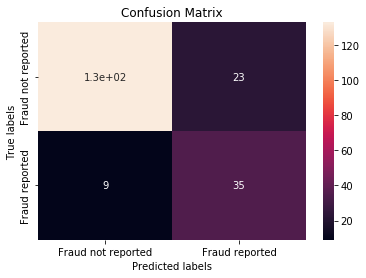

In [278]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10,
                              border_count = 100
                            )

catmodel.fit(X_train, y_train)

y_pred = catmodel.predict(X_train)
train_auc = roc_auc_score(y_train, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

0:	learn: 0.6851784	total: 3.79ms	remaining: 1.89s
1:	learn: 0.6782167	total: 6.89ms	remaining: 1.71s
2:	learn: 0.6727235	total: 9.75ms	remaining: 1.61s
3:	learn: 0.6671742	total: 12.7ms	remaining: 1.57s
4:	learn: 0.6617134	total: 15.1ms	remaining: 1.5s
5:	learn: 0.6552865	total: 17.2ms	remaining: 1.42s
6:	learn: 0.6479308	total: 19ms	remaining: 1.34s
7:	learn: 0.6412862	total: 21ms	remaining: 1.29s
8:	learn: 0.6348146	total: 22.7ms	remaining: 1.24s
9:	learn: 0.6288034	total: 24.1ms	remaining: 1.18s
10:	learn: 0.6241586	total: 25.6ms	remaining: 1.14s
11:	learn: 0.6188647	total: 26.9ms	remaining: 1.09s
12:	learn: 0.6124005	total: 28.3ms	remaining: 1.06s
13:	learn: 0.6068739	total: 29.7ms	remaining: 1.03s
14:	learn: 0.6027075	total: 31ms	remaining: 1s
15:	learn: 0.5987506	total: 32.3ms	remaining: 978ms
16:	learn: 0.5936862	total: 33.8ms	remaining: 961ms
17:	learn: 0.5890747	total: 35.3ms	remaining: 946ms
18:	learn: 0.5854410	total: 36.8ms	remaining: 932ms
19:	learn: 0.5816975	total: 38.4

237:	learn: 0.3175940	total: 370ms	remaining: 407ms
238:	learn: 0.3171890	total: 372ms	remaining: 406ms
239:	learn: 0.3167941	total: 373ms	remaining: 404ms
240:	learn: 0.3164870	total: 375ms	remaining: 403ms
241:	learn: 0.3160661	total: 377ms	remaining: 401ms
242:	learn: 0.3158980	total: 378ms	remaining: 400ms
243:	learn: 0.3156672	total: 380ms	remaining: 399ms
244:	learn: 0.3153624	total: 382ms	remaining: 397ms
245:	learn: 0.3151718	total: 383ms	remaining: 396ms
246:	learn: 0.3147329	total: 385ms	remaining: 394ms
247:	learn: 0.3145648	total: 387ms	remaining: 393ms
248:	learn: 0.3142938	total: 388ms	remaining: 392ms
249:	learn: 0.3141228	total: 390ms	remaining: 390ms
250:	learn: 0.3137426	total: 392ms	remaining: 389ms
251:	learn: 0.3135491	total: 394ms	remaining: 387ms
252:	learn: 0.3133779	total: 396ms	remaining: 386ms
253:	learn: 0.3126834	total: 398ms	remaining: 385ms
254:	learn: 0.3123586	total: 399ms	remaining: 383ms
255:	learn: 0.3120736	total: 401ms	remaining: 382ms
256:	learn: 

481:	learn: 0.2710503	total: 736ms	remaining: 27.5ms
482:	learn: 0.2706573	total: 739ms	remaining: 26ms
483:	learn: 0.2705576	total: 741ms	remaining: 24.5ms
484:	learn: 0.2703983	total: 743ms	remaining: 23ms
485:	learn: 0.2700564	total: 745ms	remaining: 21.5ms
486:	learn: 0.2699258	total: 747ms	remaining: 19.9ms
487:	learn: 0.2698329	total: 748ms	remaining: 18.4ms
488:	learn: 0.2696927	total: 750ms	remaining: 16.9ms
489:	learn: 0.2696257	total: 752ms	remaining: 15.3ms
490:	learn: 0.2695368	total: 754ms	remaining: 13.8ms
491:	learn: 0.2693764	total: 756ms	remaining: 12.3ms
492:	learn: 0.2693373	total: 757ms	remaining: 10.8ms
493:	learn: 0.2692393	total: 759ms	remaining: 9.22ms
494:	learn: 0.2691421	total: 761ms	remaining: 7.68ms
495:	learn: 0.2691049	total: 763ms	remaining: 6.15ms
496:	learn: 0.2690257	total: 766ms	remaining: 4.62ms
497:	learn: 0.2688922	total: 768ms	remaining: 3.08ms
498:	learn: 0.2687975	total: 770ms	remaining: 1.54ms
499:	learn: 0.2687193	total: 772ms	remaining: 0us


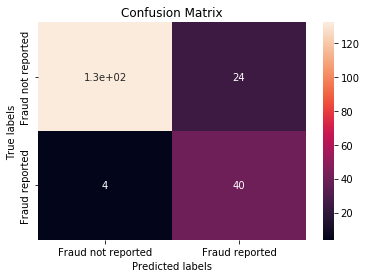

In [351]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10,
                              border_count = 100
                            )

catmodel.fit(X_train_OS, y_train_OS)

y_pred = catmodel.predict(X_train_OS)
train_auc = roc_auc_score(y_train_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_val, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_val, y_pred)

| Algorithm | Train_AUC | Val_AUC | Val_Accuracy
| --- | --- | --- |
| Logistic Regression | 0.5996 | 0.5498 | 0.775
| Decision Tree | 0.8909 | 0.8913 | 0.835
| KNN | 0.7944 | 0.5308 | 0.75
| Random Forest | 0.9477 | 0.8655 | 0.79
| **XGBoost** | **0.8936** | **0.8925** | **0.86** |
| XGBoost - SMOTE | 0.9653 | 0.8811 | 0.85 |
| LightGBM | 0.8510 | 0.8126 | 0.835
| LightGBM - SMOTE | 0.9123 | 0.8190 | 0.845
| CatBoost | 0.8706 | 0.8240 | 0.84
| **CatBoost - SMOTE** | **0.9067** | **0.8776** | **0.86**

**CatBoost outperformed the LightGBM, and gave very similar results to XGBoost**

**XGBoost and CatBoost with SMOTE, gives considerably good results, so we will check how these two model perform on test dataset** 

# War between XGBoost and CatBoost

# XGBoost

In [357]:
y_train_full = df_train_full.fraud_reported.values

del df_train_full['fraud_reported']

In [358]:
train_full_dicts = df_train_full.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(train_full_dicts)
X_test = dv.transform(test_dicts)

In [359]:
y_train_full.shape, y_test.shape

((800,), (200,))

In [360]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

[15:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.8860487903770781
test auc: 0.8531385708645874
accuracy score: 0.81


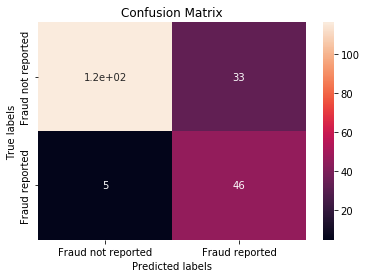

In [423]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

xgbmodel = xgb.train(xgb_params, dtrain_full, num_boost_round=75)

y_pred = xgbmodel.predict(dtrain_full)
train_auc = roc_auc_score(y_train_full, y_pred)
print("Train auc: " + str(train_auc))

y_pred = xgbmodel.predict(dtest)
test_auc = roc_auc_score(y_test, y_pred)
print("test auc: " + str(test_auc))

y_pred = xgbmodel.predict(dtest)
y_pred = (y_pred > 0.3)
acc = accuracy_score(y_test, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_test, y_pred)

In [376]:
OS = SMOTE(sampling_strategy=0.9, random_state=1)

X_train_full_OS, y_train_full_OS = OS.fit_resample(X_train_full, y_train_full)

0:	learn: 0.6844921	total: 5.82ms	remaining: 2.9s
1:	learn: 0.6777124	total: 10.5ms	remaining: 2.61s
2:	learn: 0.6701745	total: 13.8ms	remaining: 2.29s
3:	learn: 0.6650245	total: 16.6ms	remaining: 2.06s
4:	learn: 0.6597681	total: 18.8ms	remaining: 1.86s
5:	learn: 0.6523491	total: 21.4ms	remaining: 1.76s
6:	learn: 0.6448751	total: 24ms	remaining: 1.69s
7:	learn: 0.6372198	total: 26.3ms	remaining: 1.62s
8:	learn: 0.6297392	total: 28.2ms	remaining: 1.54s
9:	learn: 0.6252623	total: 30.2ms	remaining: 1.48s
10:	learn: 0.6184977	total: 32.3ms	remaining: 1.44s
11:	learn: 0.6116330	total: 34.2ms	remaining: 1.39s
12:	learn: 0.6052330	total: 35.9ms	remaining: 1.34s
13:	learn: 0.5991108	total: 37.7ms	remaining: 1.31s
14:	learn: 0.5953467	total: 39.4ms	remaining: 1.27s
15:	learn: 0.5891401	total: 41.1ms	remaining: 1.24s
16:	learn: 0.5829638	total: 42.9ms	remaining: 1.22s
17:	learn: 0.5770699	total: 45.2ms	remaining: 1.21s
18:	learn: 0.5713252	total: 46.8ms	remaining: 1.18s
19:	learn: 0.5656242	tota

218:	learn: 0.3135279	total: 374ms	remaining: 481ms
219:	learn: 0.3134027	total: 377ms	remaining: 479ms
220:	learn: 0.3131198	total: 378ms	remaining: 478ms
221:	learn: 0.3128558	total: 380ms	remaining: 476ms
222:	learn: 0.3126205	total: 382ms	remaining: 475ms
223:	learn: 0.3117983	total: 384ms	remaining: 473ms
224:	learn: 0.3114615	total: 386ms	remaining: 472ms
225:	learn: 0.3112885	total: 388ms	remaining: 470ms
226:	learn: 0.3111352	total: 390ms	remaining: 468ms
227:	learn: 0.3109179	total: 391ms	remaining: 467ms
228:	learn: 0.3107408	total: 393ms	remaining: 466ms
229:	learn: 0.3106134	total: 395ms	remaining: 464ms
230:	learn: 0.3103776	total: 397ms	remaining: 463ms
231:	learn: 0.3102347	total: 399ms	remaining: 461ms
232:	learn: 0.3099653	total: 401ms	remaining: 460ms
233:	learn: 0.3096058	total: 403ms	remaining: 458ms
234:	learn: 0.3092564	total: 405ms	remaining: 456ms
235:	learn: 0.3089225	total: 407ms	remaining: 455ms
236:	learn: 0.3082979	total: 408ms	remaining: 453ms
237:	learn: 

420:	learn: 0.2752203	total: 739ms	remaining: 139ms
421:	learn: 0.2751353	total: 741ms	remaining: 137ms
422:	learn: 0.2750338	total: 744ms	remaining: 135ms
423:	learn: 0.2747881	total: 747ms	remaining: 134ms
424:	learn: 0.2747207	total: 749ms	remaining: 132ms
425:	learn: 0.2745780	total: 751ms	remaining: 130ms
426:	learn: 0.2743919	total: 753ms	remaining: 129ms
427:	learn: 0.2742790	total: 755ms	remaining: 127ms
428:	learn: 0.2741229	total: 757ms	remaining: 125ms
429:	learn: 0.2739964	total: 760ms	remaining: 124ms
430:	learn: 0.2739070	total: 762ms	remaining: 122ms
431:	learn: 0.2738443	total: 763ms	remaining: 120ms
432:	learn: 0.2737423	total: 765ms	remaining: 118ms
433:	learn: 0.2736399	total: 767ms	remaining: 117ms
434:	learn: 0.2735565	total: 769ms	remaining: 115ms
435:	learn: 0.2734495	total: 771ms	remaining: 113ms
436:	learn: 0.2733949	total: 775ms	remaining: 112ms
437:	learn: 0.2728351	total: 777ms	remaining: 110ms
438:	learn: 0.2726276	total: 779ms	remaining: 108ms
439:	learn: 

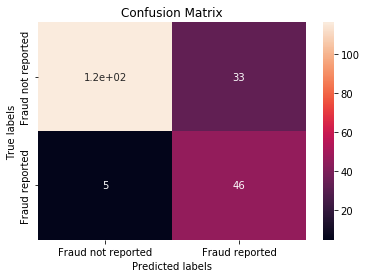

In [377]:
catmodel = CatBoostClassifier(depth = 2,
                              iterations = 500,
                              learning_rate = 0.01, 
                              l2_leaf_reg = 10,
                              border_count = 100
                            )

catmodel.fit(X_train_full_OS, y_train_full_OS)

y_pred = catmodel.predict(X_train_full_OS)
train_auc = roc_auc_score(y_train_full_OS, y_pred)
print("Train auc: " + str(train_auc))

y_pred = catmodel.predict(X_test)
val_auc = roc_auc_score(y_test, y_pred)
print("Val auc: " + str(val_auc))

acc = accuracy_score(y_test, y_pred)
print("accuracy score: " + str(acc))

plot_confusion_matrix(y_test, y_pred)

**As XGBoost gives slightly better auc on test dataset, we will keep the XGBoost as our final model**

# Final Model

In [386]:
train_full_dicts = df_train_full.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train_full = dv.fit_transform(train_full_dicts)
X_test = dv.transform(test_dicts)

dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

[11:03:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train auc: 0.8860487903770781
Test auc: 0.8531385708645874
Test accuracy score: 0.81


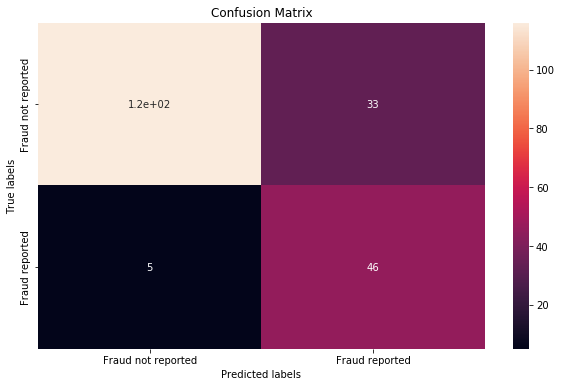

In [433]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 5,
    
    'objective': 'binary:logistic',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain_full, num_boost_round=75)

y_pred = model.predict(dtrain_full)
train_auc = roc_auc_score(y_train_full, y_pred)
print("Train auc: " + str(train_auc))

y_pred = model.predict(dtest)
val_auc = roc_auc_score(y_test, y_pred)
print("Test auc: " + str(val_auc))

y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy score: " + str(acc))

plot_confusion_matrix(y_test, y_pred)

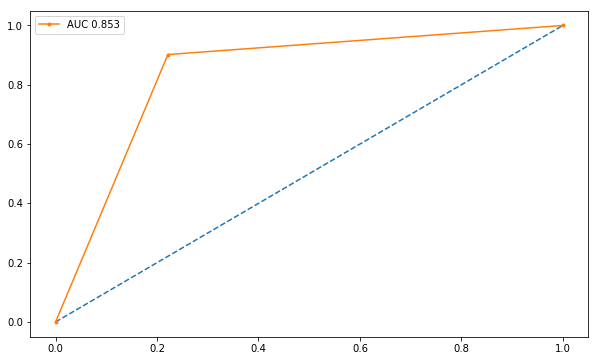

In [434]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot no skill
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='AUC 0.853')
plt.legend()

In [431]:
print('\n Classification Report:\n', classification_report(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       149
           1       0.58      0.90      0.71        51

    accuracy                           0.81       200
   macro avg       0.77      0.84      0.78       200
weighted avg       0.86      0.81      0.82       200



In [400]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x22f9a3282b0>)

# Save the model

In [401]:
import pickle

output_file = 'model_xgb.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

# Random customer from Test data

In [406]:
df_test.to_csv("customer_test.csv")

In [410]:
customer_number = 23

In [411]:
import json
customer = df_test.iloc[customer_number-1].to_json()
customer = json.loads(customer)
customer

{'age': 37,
 'authorities_contacted': 'Other',
 'auto_make': 'Nissan',
 'auto_model': 'Maxima',
 'bodily_injuries': 2,
 'capital-gains': 0,
 'capital-loss': -35900,
 'collision_type': 'Rear Collision',
 'incident_city': 'Arlington',
 'incident_hour_of_the_day': 13,
 'incident_severity': 'Major Damage',
 'incident_state': 'VA',
 'incident_type': 'Single Vehicle Collision',
 'injury_claim': 5010,
 'insured_education_level': 'Associate',
 'insured_hobbies': 'sleeping',
 'insured_occupation': 'tech-support',
 'insured_relationship': 'unmarried',
 'insured_sex': 'FEMALE',
 'months_as_customer': 145,
 'number_of_vehicles_involved': 1,
 'police_report_available': 'NO',
 'policy_annual_premium': 1434.27,
 'policy_csl': '250/500',
 'policy_deductable': 2000,
 'policy_state': 'OH',
 'property_claim': 10020,
 'property_damage': 'NO',
 'total_claim_amount': 55110,
 'umbrella_limit': 0,
 'vehicle_age': 16,
 'vehicle_claim': 40080,
 'witnesses': 3}

In [412]:
def predict_single(customer, dv, model):
    Xcustomer = dv.transform([customer])
    dcustomer = xgb.DMatrix(Xcustomer, feature_names=dv.get_feature_names())
    y_pred = model.predict(dcustomer)
    return y_pred[0]

In [413]:
predict_single(customer, dv, model)

0.5685502